In [95]:
import pandas as pd

In [96]:
df = pd.read_csv("../data/fromAPI/cleaned_hourly_all.csv")

In [97]:
date_format = "%Y-%m-%d %H:%M:%S"
df["arrival_plan"] = pd.to_datetime(df["arrival_plan"], format=date_format)
df["departure_plan"] = pd.to_datetime(df["departure_plan"], format=date_format)
df["arrival_change"] = pd.to_datetime(df["arrival_change"], format=date_format)
df["departure_change"] = pd.to_datetime(df["departure_change"], format=date_format)
df["arrival_plan_hour"] = df["arrival_plan"].dt.hour


In [98]:
df.dropna(subset=["arrival_plan"], inplace=True)

In [99]:
# Set index to datetime
df.set_index('arrival_plan', inplace=True)



In [100]:
# Select only numeric columns for resampling
numeric_cols = df.select_dtypes(include=['float64', 'int64'])

# Resample to hourly data and calculate the mean
hourly_data = numeric_cols.resample('h').mean()

In [103]:
hourly_data.iloc[28,5] = hourly_data[hourly_data["arrival_plan_hour"] == 15].arrival_delay_m.median()
hourly_data.iloc[29,5] = hourly_data[hourly_data["arrival_plan_hour"] == 16].arrival_delay_m.median()
hourly_data.iloc[30,5] = hourly_data[hourly_data["arrival_plan_hour"] == 17].arrival_delay_m.median()

In [124]:
tsa = hourly_data[["arrival_delay_m"]]

In [125]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
tsa["arrival_delay_m"] = scaler.fit_transform(hourly_data[["arrival_delay_m"]])

/var/folders/xc/x124yzd57d906mgtpgc25wkh0000gn/T/ipykernel_69292/2159634177.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tsa["arrival_delay_m"] = scaler.fit_transform(hourly_data[["arrival_delay_m"]])


In [126]:
tsa

,arrival_delay_m
arrival_plan,
2024-06-23 12:00:00,0.640429
2024-06-23 13:00:00,0.223482
2024-06-23 14:00:00,0.230500
2024-06-23 15:00:00,0.230230
2024-06-23 16:00:00,0.271804
...,...
2024-06-27 11:00:00,0.491567
2024-06-27 12:00:00,0.519128
2024-06-27 13:00:00,0.527879


In [127]:
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

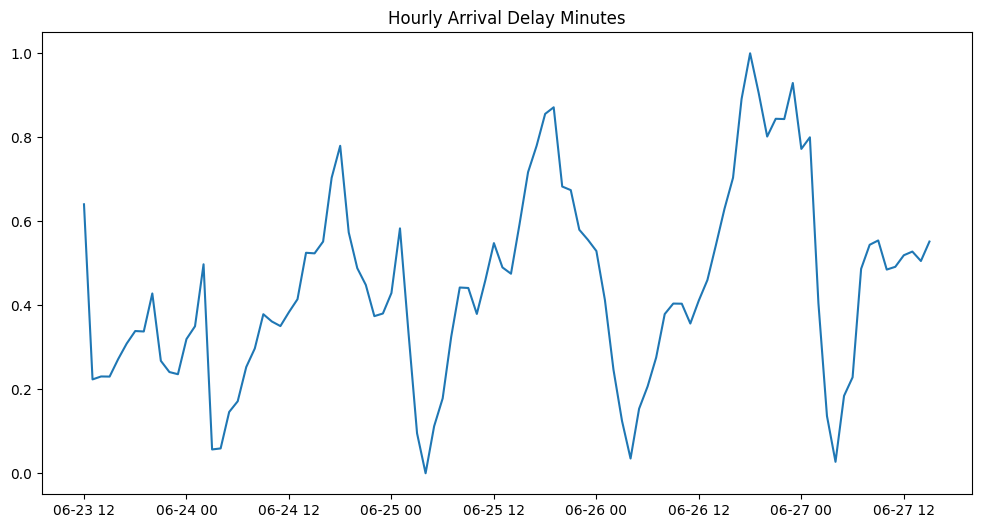

In [128]:
# Plot the time series
plt.figure(figsize=(12, 6))
plt.plot(tsa['arrival_delay_m'])
plt.title('Hourly Arrival Delay Minutes')
plt.show()

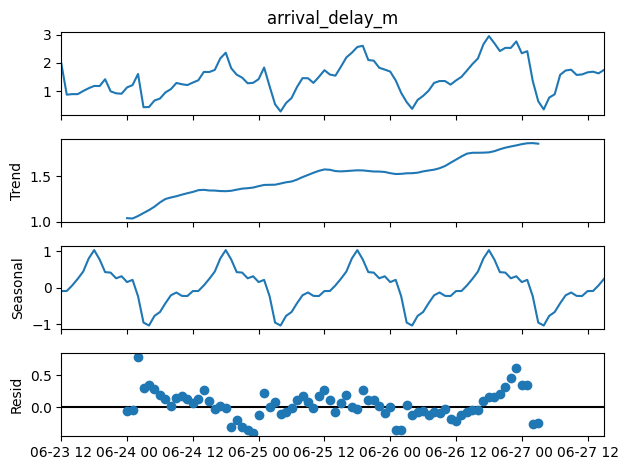

In [129]:
decomposition = seasonal_decompose(hourly_data['arrival_delay_m'], model='additive')
decomposition.plot()
plt.show()

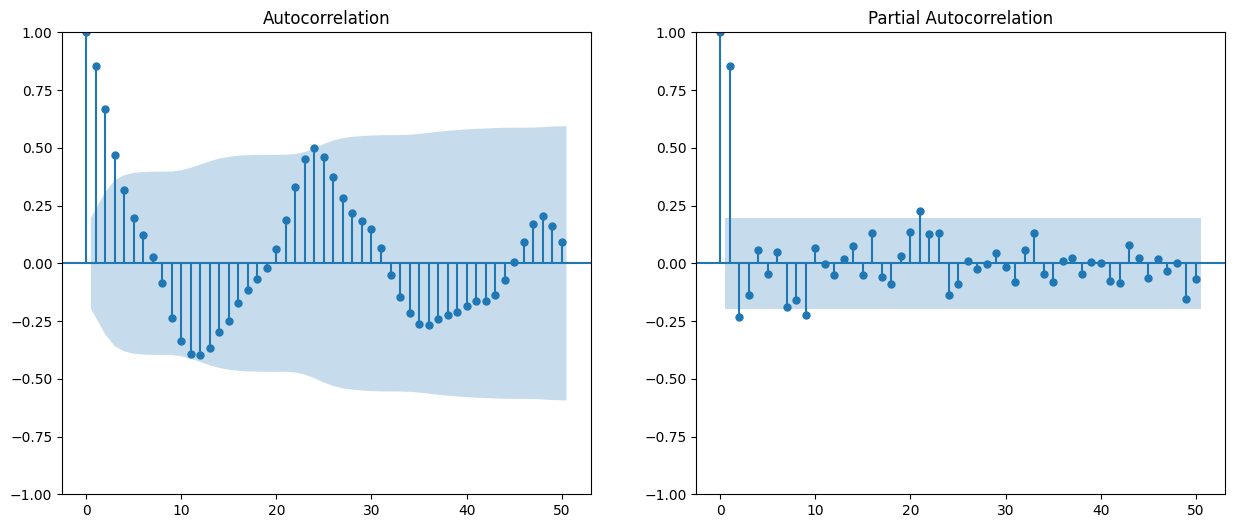

In [130]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# ACF and PACF plots
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
plot_acf(tsa['arrival_delay_m'], lags=50, ax=axes[0])
plot_pacf(tsa['arrival_delay_m'], lags=50, ax=axes[1])
plt.show()

In [131]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Fit the SARIMA model
model = SARIMAX(tsa['arrival_delay_m'], 
                order=(1, 1, 1), #CHANGE
                seasonal_order=(1, 1, 1, 24))#CHANGE
model_fit = model.fit(disp=False)
print(model_fit.summary())

/Users/nokkyu/Documents/greenbootcamps/FinalProject/SavingDB/.venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


                                     SARIMAX Results                                      
Dep. Variable:                    arrival_delay_m   No. Observations:                  100
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 24)   Log Likelihood                  64.210
Date:                            Sat, 06 Jul 2024   AIC                           -118.420
Time:                                    17:33:09   BIC                           -106.832
Sample:                                06-23-2024   HQIC                          -113.793
                                     - 06-27-2024                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7258      0.113      6.426      0.000       0.504       0.947
ma.L1         -0.9887      0.410   

/Users/nokkyu/Documents/greenbootcamps/FinalProject/SavingDB/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


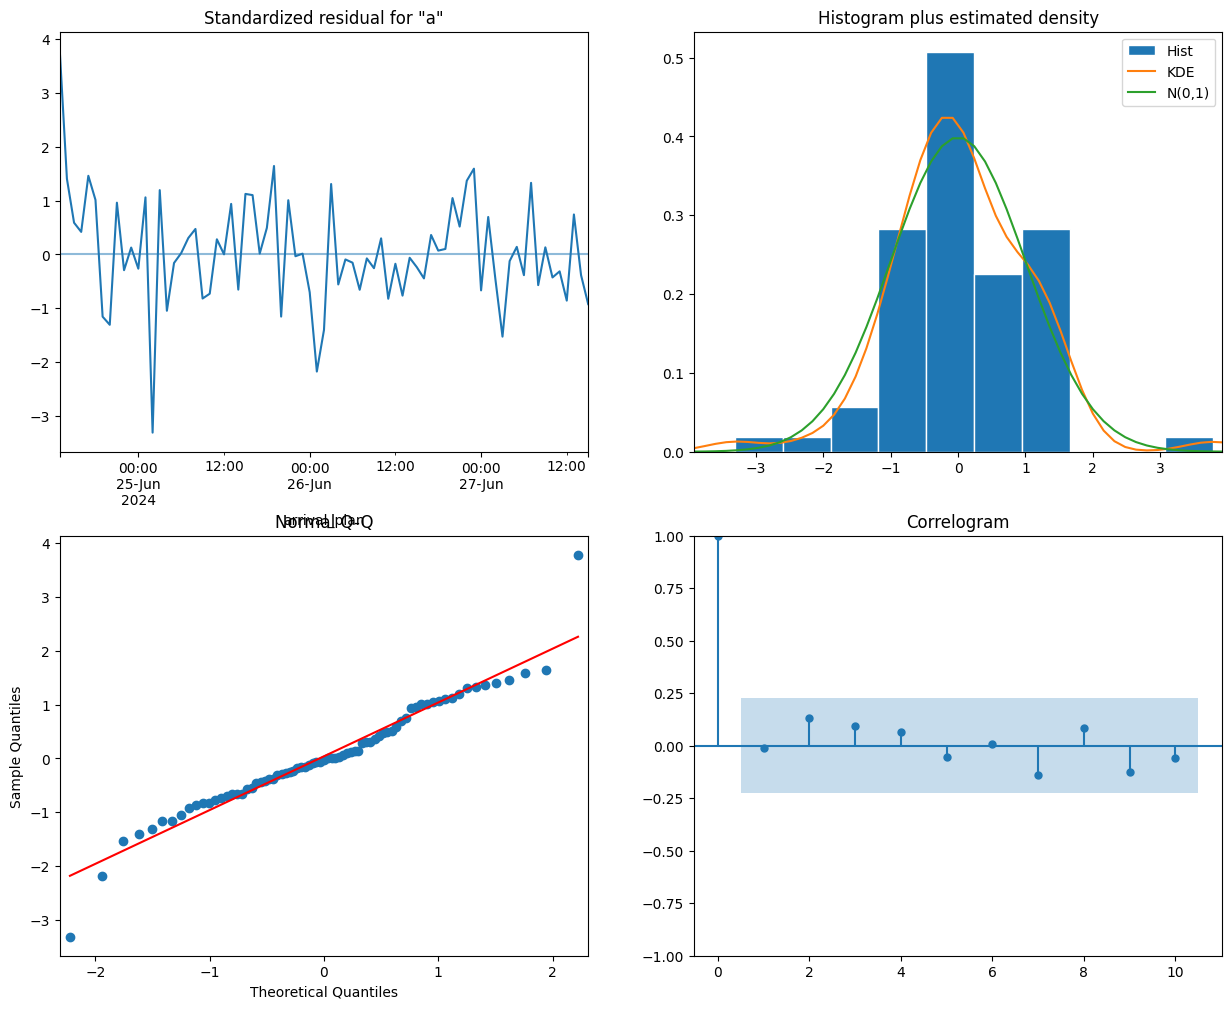

In [132]:
# Diagnostic plots
model_fit.plot_diagnostics(figsize=(15, 12))
plt.show()

/var/folders/xc/x124yzd57d906mgtpgc25wkh0000gn/T/ipykernel_69292/2558859481.py:4: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  forecast_index = pd.date_range(start=df.index[-1], periods=forecast_steps + 1, freq='H')[1:]


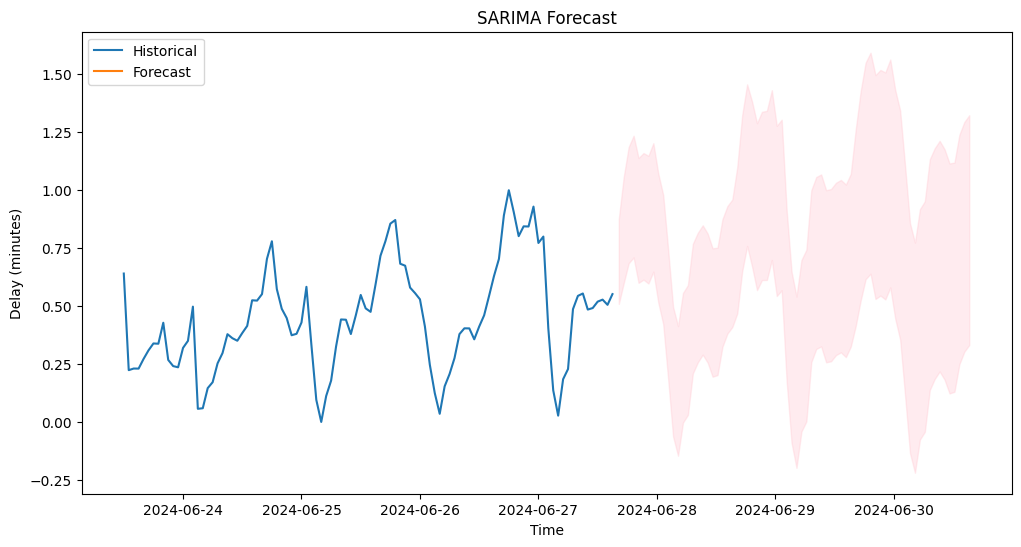

In [133]:
# Forecasting the next 24 hours
forecast_steps = 72
forecast = model_fit.get_forecast(steps=forecast_steps)
forecast_index = pd.date_range(start=df.index[-1], periods=forecast_steps + 1, freq='H')[1:]
forecast_series = pd.Series(forecast.predicted_mean, index=forecast_index)
confidence_intervals = forecast.conf_int()

# Plot the forecast
plt.figure(figsize=(12, 6))
plt.plot(tsa['arrival_delay_m'], label='Historical')
plt.plot(forecast_series, label='Forecast')
plt.fill_between(forecast_index, confidence_intervals.iloc[:, 0], confidence_intervals.iloc[:, 1], color='pink', alpha=0.3)
plt.title('SARIMA Forecast')
plt.xlabel('Time')
plt.ylabel('Delay (minutes)')
plt.legend()
plt.show()

outlier detection
combine the two datasets to one to predict a week
show accuraacy with second dataset

test bundesländer if they follow the pattern